<a href="https://colab.research.google.com/github/sleepsonrockss/Segmentation/blob/main/A6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Intro**
To load the dataset, you'll need to add the specified folder to your Google drive and then mount your drive here.

Link to dataset: https://drive.google.com/drive/folders/1zTchwEACSV7O4Nv9m4jWmaOAHJqMt_DU?usp=sharing

Make sure you hit "Add to Drive" so you can access it via this notebook.

⚠️ WARNING: 30 epochs may take 15-30 minutes on a T4 GPU with high RAM enabled. Plan ahead!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import nibabel as nib
import torch.nn.functional as F
from torchvision.transforms import v2 as t
import random
import pickle
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import imageio
import time
from IPython.display import Image as IPImage
import gc
import torchvision.models as models
import cv2
from statistics import mode

# **ACDC Loader**
Nothing needed here! Don't change stuff or something might break

In [ ]:
class ACDC_2D_Dataset(Dataset):
    def __init__(
        self,
        info_file,
        image_dir,
        train=True,
        threshold=35,
        output_res=128,
        return_type="image",
        preprocessing=True,
        joint_transform = None,
        image_transform = None,
        mask_transform = None,
    ):

        self.return_type = (
            return_type if return_type == "image" or return_type == "data" else "image"
        )
        self.data = dict() if return_type == "data" else None
        self.preprocessing = preprocessing
        self.info_file = pd.read_csv(info_file)
        self.image_dir = image_dir
        self.train = train
        self.output_res = output_res
        self.cumulative = [0]
        self.threshold = threshold
        self.process_len()
        self.joint_transform = joint_transform
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return np.sum(self.info_file["z-len"] * 2)

    def extract_details(self, idx):
        patient_id = None
        ed = True
        row = None
        for i in range(1, len(self.cumulative)):
            if idx < self.cumulative[i]:
                patient_index = i
                idx = idx - self.cumulative[i - 1]
                patient_id = f"patient{patient_index:03d}" if self.train else f"patient1{patient_index:02d}"
                row = self.info_file[self.info_file["Patient ID"] == patient_id]
                thickness = int(row["z-len"].iloc[0])
                if idx >= thickness:
                    ed = False
                    idx = idx - thickness
                break
        if self.data != None:
            self.data["ES/ED"] = "ED" if ed else "ES"
            self.data["idx"] = idx
            for col in row.columns:
                self.data[col] = row[col].iloc[0]
        return patient_id, ed, row, idx

    def preprocess_crop(self, idx, patient_id, ed, row, image, mask):

        reference_loc = os.path.join(
            self.image_dir,
            "training" if self.train else "testing",
            patient_id,
            f"{patient_id}_frame{row['ES'].iloc[0] if ed else row['ED'].iloc[0]:02d}.nii",
        )

        reference = torch.tensor(
            nib.load(reference_loc).get_fdata()[:, :, idx]
        )  # Convert to torch tensor

        diff = torch.abs(reference - image)

        y_coords, x_coords = (None, None)
        i = 0
        while y_coords is None or x_coords is None:
            y_coords, x_coords = torch.where(diff > self.threshold + i)
            i += 1

        centroid_y = int(torch.mean(y_coords.float()))
        centroid_x = int(torch.mean(x_coords.float()))

        crop_half_size = self.output_res // 2

        crop_top = max(0, centroid_y - crop_half_size)
        crop_left = max(0, centroid_x - crop_half_size)
        crop_top = (
            crop_top
            if crop_top + self.output_res < image.shape[0]
            else (image.shape[0] - self.output_res)
        )
        crop_left = (
            crop_left
            if crop_left + self.output_res < image.shape[1]
            else (image.shape[1] - self.output_res)
        )

        image = image[
            crop_top : crop_top + self.output_res,
            crop_left : crop_left + self.output_res,
        ]
        mask = mask[
            crop_top : crop_top + self.output_res,
            crop_left : crop_left + self.output_res,
        ]

        if self.data != None:
            self.data["y-cord"] = crop_top
            self.data["x-cord"] = crop_left
            self.data["diff"] = diff

        return image.float(), mask.float()

    def __getitem__(self, idx):

        if idx >= self.__len__():
            raise IndexError("Dataset index out of range")

        patient_id, ed, row, idx = self.extract_details(idx)

        image_loc = os.path.join(
            self.image_dir,
            "training" if self.train else "testing",
            patient_id,
            f"{patient_id}_frame{row['ED'].iloc[0] if ed else row['ES'].iloc[0]:02d}.nii",
        )
        mask_loc = os.path.join(
            self.image_dir,
            "training" if self.train else "testing",
            patient_id,
            f"{patient_id}_frame{row['ED'].iloc[0] if ed else row['ES'].iloc[0]:02d}_gt.nii",
        )
        image = torch.tensor(nib.load(image_loc).get_fdata())[:, :, idx]
        mask = torch.tensor(nib.load(mask_loc).get_fdata())[:, :, idx]

        image, mask = (
            self.preprocess_crop(idx, patient_id, ed, row, image, mask)
            if self.preprocessing
            else (image, mask)
        )

        image = nn.functional.normalize(image.unsqueeze(0))  # Making it single channel
        mask = F.one_hot(mask.to(torch.int64), num_classes=4).permute(2, 0, 1)

        if self.image_transform is not None:
            image = self.image_transform(image)

        if self.mask_transform is not None:
            mask = self.mask_transform(mask)

        if self.joint_transform is not None:
            image_and_mask = torch.cat([image, mask], dim=0)
            transformed = self.joint_transform(image_and_mask)
            image = transformed[: image.shape[0], ...]
            mask = transformed[image.shape[0] :, ...]

        if self.return_type == "image":
            return image, mask
        else:  # It should not be on during training
            return image, mask, self.data

    def process_len(self):
        for val in self.info_file["z-len"]:
            self.cumulative.append(self.cumulative[-1] + (val * 2))

    def return_type(return_type):
        self.return_type = return_type

# **Utilities**
You will need to implement stuff. Study the provided code for guidance.


*   ☑️ Visualization of 20 samples (raw image, ground truth mask) [total: 0.5]

In [ ]:
def show_img(img1, img2=None, name1="Image", name2="Mask"):
    if len(img1.shape) == 3:
        img1 = one_hot_to_label(img1) if img1.shape[0] > 1 else img1.squeeze(0)
    if img2 != None and len(img2.shape) == 3:
        img2 = one_hot_to_label(img2) if img2.shape[0] > 1 else img2.squeeze(0)

    if img2 is None:
        print(name1, img1.shape)
        plt.imshow(img1, cmap="gray")
        plt.title(name1)
        plt.show()
    else:
        print(name1, img1.shape, name2, img2.shape)
        plt.figure(figsize=(15, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(img1, cmap="gray")
        plt.title(name1)

        plt.subplot(1, 2, 2)
        plt.imshow(img2, cmap="gray")
        plt.title(name2)

        plt.show()


# Converts multiple channel to labeled data
def one_hot_to_label(mask, axis=0):
    if isinstance(mask, np.ndarray):
        mask = np.argmax(mask, axis=axis)
    elif isinstance(mask, torch.Tensor):
        mask = torch.argmax(mask, dim=axis)
    else:
        raise ValueError("Input must be a numpy array or a torch tensor")

    return mask.astype(np.uint8) if isinstance(mask, np.ndarray) else mask.int()

def label_to_one_hot(label_tensor, num_classes):

    # Initialize one-hot encoded mask
    onehot_mask = torch.zeros(num_classes, *label_tensor.shape, dtype=torch.uint8)

    # Use scatter to set one-hot encoding
    onehot_mask.scatter_(0, label_tensor.unsqueeze(0), 1)

    return onehot_mask


def post_process(image, isMask=True, isPred=False):
    if isMask:
        if isPred:
            image = F.softmax(image, dim=-3)
        image = torch.argmax(image, dim=-3)
    return image if image.dim() == 2 else image.squeeze(0)


def remove_outliers(mask, debug = False):

    label_mask = None
    if len(mask.shape) == 2: # Meaning it's labeled
        label_mask = mask
        mask = label_to_one_hot(mask, 4)
    else:  # When it's one hot encoded
        label_mask = one_hot_to_label(mask)

    mask = mask.to(torch.uint8).cpu().numpy()
    for i, channel in enumerate(mask):

        if i ==0:
            continue

        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(channel)

        stats = np.array(sorted(stats.tolist(), key=lambda x: x[4], reverse=True))

        for j in range(2, len(stats)):
            top_left = (stats[j, 0], stats[j, 1])
            bottom_right = (stats[j, 0]+stats[j, 2]-1, stats[j, 1]+stats[j, 3]-1)
            replace_label = mode(
                [
                    label_mask[top_left[1]-1, top_left[0]-1].item(),
                    label_mask[bottom_right[1], bottom_right[0]].item(),
                    label_mask[top_left[1]-1, bottom_right[0]].item(),
                    label_mask[bottom_right[1], top_left[0]-1].item()
                ]
            )
            if debug:
                show_img(channel)
                print(replace_label, [
                    label_mask[top_left[1]-1, top_left[0]-1].item(),
                    label_mask[bottom_right[1], bottom_right[0]].item(),
                    label_mask[top_left[1]-1, bottom_right[0]].item(),
                    label_mask[bottom_right[1], top_left[0]-1].item()
                ])
            for k in range(top_left[0], bottom_right[0] + 1):
                for l in range(top_left[1], bottom_right[1] + 1):
                    mask[replace_label, l, k] = 1 if mask[i, l, k] == 1 else 0
                    mask[i, l, k] = 0
            if debug:
                show_img(mask)
    return torch.tensor(mask).to(torch.int64)


def load_train_data(dir_loc='train_data'):
    res = None
    with open(f"{dir_loc}/train_data.pkl", 'rb') as fp:
        res = pickle.load(fp)
    return res

def create_gif(folder_path, gif_path='images.gif'):
    # Get a list of all jpg files in the folder
    file_list = [file for file in os.listdir(folder_path) if file.endswith(".jpg")]

    # Sort the file list based on their numbers
    file_list.sort(key=lambda x: int(x.split('.')[0]))

    # Check if any files were found
    if not file_list:
        print("No images found in the folder to create a GIF.")
        return
    # Open each image and append it to images list
    images = []
    for file in file_list:
        file_path = os.path.join(folder_path, file)
        img = Image.open(file_path)
        images.append(img)

    # Save images as a gif
    images[0].save(gif_path, save_all=True, append_images=images[1:], duration=500, loop=0)

    return gif_path

In [ ]:
def show_img_with_pred(image, mask, pred_mask):
    """Displays the image, ground truth mask, and predicted mask side by side."""

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display the original image
    if image.ndim == 3 and image.shape[0] == 1:
        image = image.squeeze(0)
    axes[0].imshow(image, cmap='gray' if image.ndim == 2 else None)
    axes[0].set_title("Image")
    axes[0].axis('off')

    # Display the ground truth mask
    if mask.ndim == 3 and mask.shape[0] > 1:
        # If the mask has multiple channels, choose one channel for visualization
        # or use argmax to get the label map
        mask = np.argmax(mask, axis=0)
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Ground Truth")
    axes[1].axis('off')

    # Display the predicted mask
    if pred_mask.ndim == 3 and pred_mask.shape[0] > 1:
        # If the prediction has multiple channels, choose one channel for visualization
        pred_mask = np.argmax(pred_mask, axis=0)

    axes[2].imshow(pred_mask, cmap='gray')
    axes[2].set_title("Prediction")
    axes[2].axis('off')

    plt.show()

def visualize_predictions(model, dataset, indices, device):
    model.to(device)
    model.eval()
    with torch.no_grad():
        for idx in indices:
            image, gt_mask = dataset[idx]
            image = image.unsqueeze(0).to(device)

            # Predict the mask
            raw_pred = model(image)
            pred_mask = post_process(raw_pred, isMask=True, isPred=True).cpu().numpy()

            # Convert to numpy for visualization
            image = image.squeeze(0).cpu().numpy()
            if image.shape[0] == 1:  # If it's a single-channel image
                image = image.squeeze(0)
            else:  # If it's a multi-channel image
                image = image.transpose(1, 2, 0)

            gt_mask = gt_mask.cpu().numpy()

            # Visualize the image, ground truth mask, and predicted mask
            show_img_with_pred(image, gt_mask, pred_mask)

In [ ]:
'''
TO DO: Using the functions above, write new code to generate a visualization of 20 samples. Each row should contain
1. raw image
2. ground truth mask
Note you don't show the predicted mask yet because we haven't trained yet!
'''

pass


# **Metrics**
You will need to implement stuff. Look at the filled in metrics for guidance.


*   ☑️ F1 Score
*   ☑️ IoU
*   ☑️ Sensitivity
*   ☑️ Specificity
*   ☑️ Precision

[total: 0.5 - you lose the full 0.5 if one of these is wrong]


In [ ]:
class WeightedDiceLoss(nn.Module):
    def __init__(self, weights = None):
        super(WeightedDiceLoss, self).__init__()
        self.weights = torch.tensor([1]*len(losses) if weights == None else weights)

    def forward(self, prediction, target):
        smooth = 1e-6
        device = prediction.device

        intersection = torch.sum(prediction * target, dim=(2, 3))
        prediction_sum = torch.sum(prediction, dim=(2, 3))
        target_sum = torch.sum(target, dim=(2, 3))

        dice_coefficient = (2 * intersection + smooth) / (
            prediction_sum + target_sum + smooth
        )

        self.weights = self.weights.to(device)
        weighted_dice_loss = torch.sum(self.weights * dice_coefficient) / torch.sum(self.weights)
        weighted_dice_loss /= prediction.shape[0]

        return 1 - weighted_dice_loss

class EmptyPenaltyLoss(nn.Module):
    def __init__(self):
        super(EmptyPenaltyLoss, self).__init__()

    def forward(self, predictions, masks):
        device = predictions.device

        main_loss = torch.tensor(0., device = device)

        for i in range(4):
            predictions_c = predictions[:, i, :, :]
            masks_c = masks[:, i, :, :]

            predictions_flat = predictions_c.view(predictions_c.size(0), -1)
            masks_flat = masks_c.view(masks_c.size(0), -1)

            mask_sum = torch.sum(masks_flat, dim = -1)
            if torch.sum(mask_sum) == 0:
                main_loss += torch.mean(predictions_flat)

        return main_loss/4.

class LVPenaltyLoss(nn.Module):
    def __init__(self):
        super(LVPenaltyLoss, self).__init__()

    def forward(self, predictions, masks):
        lv = predictions[:, 3, :, :]
        rv = masks[:, 1, :, :]
        bck = masks[:, 0, :, :]
        loss = (torch.mean(lv*rv, dim = (-1,-2)) + torch.mean(lv*bck, dim = (-1, -2)))/2
        return loss.mean()

class ComposeLoss(nn.Module):
    def __init__(self, losses, weights = None):
        super(ComposeLoss, self).__init__()
        self.losses = losses
        if len(self.losses) == 0:
            raise ValueError("Losses is empty")
        self.weights = torch.tensor([1]*len(losses) if weights == None and len(weights) != len(self.losses) else weights)

    def forward(self, predictions, masks):
        device = predictions.device
        self.weights = self.weights.to(device)
        loss = torch.tensor(0., device = device)

        for loss_f, weight in zip(self.losses, self.weights):
            loss += loss_f(predictions, masks)*weight

        return loss/torch.sum(self.weights)

class ClassAccuracy(nn.Module):
    def __init__(self, threshold=0.5, channel=0):
        super(ClassAccuracy, self).__init__()
        self.threshold = threshold
        self.channel = channel

    def forward(self, predictions, masks):

        predictions = predictions[:, self.channel, :, :]
        masks = masks[:, self.channel, :, :]

        # Convert probabilities to binary predictions using threshold
        binary_predictions = (predictions > self.threshold).float()
        # Calculate accuracy

        correct = (binary_predictions == masks).sum().item()
        total = masks.numel()  # Total number of elements in the masks tensor
        accuracy = correct / total

        return accuracy


class ClassDice(nn.Module):
    def __init__(self, threshold=0.5, channel=0):
        super(ClassDice, self).__init__()
        self.threshold = threshold
        self.channel = channel

    def forward(self, predictions, masks):

        epsilon=1e-7
        predictions = predictions[:, self.channel, :, :]
        masks = masks[:, self.channel, :, :]

        predictions_flat = predictions.view(predictions.size(0), -1)
        masks_flat = masks.view(masks.size(0), -1)

        # Calculate intersection and union
        intersection = torch.sum(predictions_flat * masks_flat, dim=1)
        union = torch.sum(predictions_flat, dim=1) + torch.sum(masks_flat, dim=1)

        # Calculate Dice score
        dice = (2. * intersection + epsilon) / (union + epsilon)

        # Average Dice score over the batch
        dice_score = torch.mean(dice)

        return dice_score

class F1Score(nn.Module):
    def __init__(self, threshold=0.5, eps=1e-7):
        super(F1Score, self).__init__()
        self.threshold = threshold
        self.eps = eps

    def forward(self, predictions, masks):
        pass

class IoU(nn.Module):
    def __init__(self, threshold=0.5, eps=1e-7):
        super(IoU, self).__init__()
        self.threshold = threshold
        self.eps = eps

    def forward(self, predictions, masks):
        pass

class Sensitivity(nn.Module):
    def __init__(self, threshold=0.5, eps=1e-7):
        super(Sensitivity, self).__init__()
        self.threshold = threshold
        self.eps = eps

    def forward(self, predictions, masks):
        pass

class Specificity(nn.Module):
    def __init__(self, threshold=0.5, eps=1e-7):
        super(Specificity, self).__init__()
        self.threshold = threshold
        self.eps = eps

    def forward(self, predictions, masks):
        pass

class Precision(nn.Module):
    def __init__(self, threshold=0.5, eps=1e-7):
        super(Precision, self).__init__()
        self.threshold = threshold
        self.eps = eps

    def forward(self, predictions, masks):
        pass

# **Defining UNET and your Choice of Model**
You will need to implement stuff. Look at the provided code for guidance.


*   ☑️ One other model of your choice.

You will add it to the training loop in the next section (which will handle training automatically).
[total: 0.5 - you will lose the full 0.5 if the model is crazy/unreasonable]

In [ ]:
class UNet_v1(nn.Module):
    def __init__(self):
        super(UNet_v1, self).__init__()

        ## Define all the layers of the architecture
        self.conv1_1 = nn.Conv2d(1, 64, 3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.max_pool1_2 = nn.MaxPool2d(2)

        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.max_pool2_3 = nn.MaxPool2d(2)

        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.max_pool3_4 = nn.MaxPool2d(2)

        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(512)
        self.max_pool4_5 = nn.MaxPool2d(2)

        self.conv5_1 = nn.Conv2d(512, 1024, 3, padding=1)
        self.bn5_1 = nn.BatchNorm2d(1024)
        self.conv5_2 = nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn5_2 = nn.BatchNorm2d(1024)

        self.upsample5_6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6_1 = nn.Conv2d(1024, 512, 3, padding=1)  ## Changes
        self.bn6_1 = nn.BatchNorm2d(512)
        self.conv6_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn6_2 = nn.BatchNorm2d(512)

        self.upsample6_7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7_1 = nn.Conv2d(512, 256, 3, padding=1)  ## Changes
        self.bn7_1 = nn.BatchNorm2d(256)
        self.conv7_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn7_2 = nn.BatchNorm2d(256)

        self.upsample7_8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8_1 = nn.Conv2d(256, 128, 3, padding=1)  ## Changes
        self.bn8_1 = nn.BatchNorm2d(128)
        self.conv8_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn8_2 = nn.BatchNorm2d(128)

        self.upsample8_9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9_1 = nn.Conv2d(128, 64, 3, padding=1)  ## Changes
        self.bn9_1 = nn.BatchNorm2d(64)
        self.conv9_2 = nn.Conv2d(64, 4, 3, padding=1)

    def forward(self, x):
        l1 = x
        l1 = F.relu(self.bn1_1(self.conv1_1(l1)))
        l1 = F.relu(self.bn1_2(self.conv1_2(l1)))

        l2 = self.max_pool1_2(l1)
        l2 = F.relu(self.bn2_1(self.conv2_1(l2)))
        l2 = F.relu(self.bn2_2(self.conv2_2(l2)))

        l3 = self.max_pool2_3(l2)
        l3 = F.relu(self.bn3_1(self.conv3_1(l3)))
        l3 = F.relu(self.bn3_2(self.conv3_2(l3)))

        l4 = self.max_pool3_4(l3)
        l4 = F.relu(self.bn4_1(self.conv4_1(l4)))
        l4 = F.relu(self.bn4_2(self.conv4_2(l4)))

        l5 = self.max_pool4_5(l4)
        l5 = F.relu(self.bn5_1(self.conv5_1(l5)))
        l5 = F.relu(self.bn5_2(self.conv5_2(l5)))

        l6 = self.upsample5_6(l5)
        l6 = torch.cat([l4, l6], dim=-3)
        l6 = F.relu(self.bn6_1(self.conv6_1(l6)))
        l6 = F.relu(self.bn6_2(self.conv6_2(l6)))

        l7 = self.upsample6_7(l6)
        l7 = torch.cat([l3, l7], dim=-3)
        l7 = F.relu(self.bn7_1(self.conv7_1(l7)))
        l7 = F.relu(self.bn7_2(self.conv7_2(l7)))

        l8 = self.upsample7_8(l7)
        l8 = torch.cat([l2, l8], dim=-3)
        l8 = F.relu(self.bn8_1(self.conv8_1(l8)))
        l8 = F.relu(self.bn8_2(self.conv8_2(l8)))

        l9 = self.upsample8_9(l8)
        l9 = torch.cat([l1, l9], dim=-3)
        l9 = F.relu(self.bn9_1(self.conv9_1(l9)))
        l9 = F.softmax(self.conv9_2(l9), dim=-3)

        out = l9
        return out

In [ ]:
'''
TO DO: implement a custom network for the ACDC dataset. Try to be thoughtful and not just copy paste something. Performance is not graded for the cutom model, so maybe take a risk!
'''
class Custom_Net(nn.Module):
    def __init__(self):
        super(Custom_Net, self).__init__()
    def forward(self, x):
        pass

# **Train, Validation, Testing**
You might want to change the training loop a bit to help with plotting

In [ ]:
def train_per_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    metric=dict(),
    device=torch.device("cpu")
):

    if device == torch.device("xla:0"):
        import torch_xla.core.xla_model as xm

    running_loss = 0.0
    last_loss = 0.0
    running_metric = [0.0] * len(metric)
    last_metric = [0.0] * len(metric)
    for i, batch in enumerate(data_loader):
        images, masks = batch
        images = images.to(device)
        masks = masks.to(device)

        # Zero gradients for every batch
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(images)

        # Compute the loss and it's gradients
        loss = loss_fn(outputs, masks)
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        if torch.device('xla:0') == device:
             xm.mark_step()

        # Gather data and report
        with torch.no_grad():
            for j, m in enumerate(metric.keys()):
                score = metric[m](outputs, masks)
                running_metric[j] += score
                last_metric[j] = running_metric[j] / (i + 1)
            running_loss += loss.item()
            last_loss = running_loss / (i + 1)

        text = f"Batch: {i:02d} "
        text += f"Loss: {last_loss:0.6f} "
        for j, m in enumerate(metric.keys()):
            text += f"{m}: {last_metric[j]:0.6f} "
        print(text, end="\r")

    return last_loss, last_metric


def val_per_epoch(
    model,
    data_loader,
    loss_fn,
    metric=dict(),
    device=torch.device("cpu")
):

    running_loss = 0.0
    last_loss = 0.0
    running_metric = [0.0] * len(metric)
    last_metric = [0.0] * len(metric)
    with torch.no_grad():
        for i, vdata in enumerate(data_loader):
            vimages, vmasks = vdata
            vimages = vimages.to(device)
            vmasks = vmasks.to(device)
            voutputs = model(vimages)

            vloss = loss_fn(voutputs, vmasks)
            for j, m in enumerate(metric.keys()):
                score = metric[m](voutputs, vmasks)
                running_metric[j] += score
                last_metric[j] = running_metric[j] / (i + 1)

            running_loss += vloss.item()
            last_loss = running_loss / (i + 1)

            text = f"Val Batch: {i:02d} "
            text += f"Val Loss: {last_loss:0.6f} "
            for j, m in enumerate(metric.keys()):
                text += f"Val {m}: {last_metric[j]:0.6f} "
            print(text, end="\r")

    return last_loss, last_metric

def train(
    DATASET,
    MODEL,
    LOSS,
    OPTIM,
    SPLIT=[0.2, 0.8],
    EPOCHS=2,
    BATCH_SIZE=32,
    DEVICE=torch.device("cpu"),
    SHUFFLE=True,
    METRIC=dict(),
    SAVE_LOC="train_data",
    SAMPLE_IMAGE=None,
    SEED=int(random.random() * 10000),
    VAL_BATCH_FACTOR=2,
    SAVE_DATA = True,
    EARLY_STOP = 'early_stop.pth',
    SCHEDULER = None
):

    if not os.path.isdir(SAVE_LOC):
        os.makedirs(SAVE_LOC)
    loss_arr = list()
    metric_dict = list()

    # Data preparation
    val_data, train_data = random_split(
        DATASET, SPLIT, torch.Generator().manual_seed(SEED)
    )

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
    val_loader = DataLoader(
        val_data, batch_size=BATCH_SIZE * VAL_BATCH_FACTOR, shuffle=SHUFFLE
    )

    # Initializing the model into GPU or CPU (Will apply TPU too)
    if torch.device('xla:0')==DEVICE:
        MODEL = MODEL.to(DEVICE)
    elif torch.cuda.device_count() == 2:
        MODEL = nn.DataParallel(MODEL, device_ids=[0, 1]).to(DEVICE)
    else:
        MODEL = MODEL.to(DEVICE)

    # Normal Training and Loss Calculation
    loss = []
    vloss = []
    metric = {}
    vmetric = {}

    for m in METRIC.keys():
        metric[m] = []
        vmetric[m] = []
    best_vloss = 0.0

    for epoch in range(EPOCHS):
        torch.cuda.empty_cache()
        gc.collect()
        t = time.time()
        print(f"Epoch: {epoch+1}")
        # Train Loss calculation
        MODEL.train(True)
        avg_loss, avg_metric = train_per_epoch(
            model=MODEL,
            data_loader=train_loader,
            loss_fn=LOSS,
            optimizer=OPTIM,
            metric=METRIC,
            device=DEVICE,
        )

        text = f"Train Loss: {avg_loss:0.10f} "
        loss.append(avg_loss)

        # Train Metric calculation
        for j, m in enumerate(METRIC.keys()):
            metric[m].append(avg_metric[j])
            text += f"{m}: {avg_metric[j]:0.10f} "

        print(text)

        # Val Loss Calculation
        MODEL.eval()
        avg_vloss, avg_vmetric = val_per_epoch(
            model=MODEL,
            data_loader=val_loader,
            loss_fn=LOSS,
            metric=METRIC,
            device=DEVICE,
        )

        text = f"Validation Loss: {avg_vloss:0.10f} "
        vloss.append(avg_vloss)

        # Val Metric Calculation
        for j, m in enumerate(METRIC.keys()):
            vmetric[m].append(avg_vmetric[j])
            text += f"Validation {m}: {avg_vmetric[j]:0.10f} "
        t = time.time()-t
        print(text)
        print(f"Time Elapsed: {t}s Time Left: {t*(EPOCHS-1-epoch)}s")
        if SAMPLE_IMAGE != None:
            with torch.no_grad():
                pred = MODEL(SAMPLE_IMAGE.to(DEVICE))
                pred = post_process(pred, isPred=True).cpu().numpy()
                pred = (pred - np.min(pred)) / (np.max(pred) - np.min(pred))
                im = Image.fromarray(np.array(pred * 255, dtype=np.uint8))
                im.save(f"{SAVE_LOC}/{epoch}.jpg")

        if avg_vloss > best_vloss:
            best_vloss = avg_vloss
            torch.save(MODEL.state_dict(), f"{SAVE_LOC}/{EARLY_STOP}")

        if SCHEDULER != None:
            if isinstance(SCHEDULER, list):
                for sch in SCHEDULER:
                    sch.step()
            else:
                SCHEDULER.step()




    if SAMPLE_IMAGE != None:
        gif_path = create_gif(SAVE_LOC, f"{SAVE_LOC}/train_data.gif")

    train_data = {
        "loss": loss,
        "vloss": vloss,
        "metric": metric,
        "vmetric": vmetric,
        "model_state_dict": MODEL.cpu().state_dict() if torch.cuda.device_count() < 2 else list(MODEL.children())[0].cpu().state_dict(),
        "optim": OPTIM,
        "save_loc": SAVE_LOC,
        "image":SAMPLE_IMAGE,
        "gif_path":create_gif(SAVE_LOC, f"{SAVE_LOC}/train_data.gif"),
    }

    if SAVE_DATA:
        with open(f"{SAVE_LOC}/train_data.pkl", "wb") as fp:
            pickle.dump(train_data, fp)
            print(f"Data Saved Successfully to {SAVE_LOC}/train_data.pkl")

    return train_data


def test(
    DATASET,
    MODEL,
    LOSS,
    THRESH = 0.8,
    DEVICE = torch.device('cpu'),
    METRICS = []
):

    avg_metric = []
    for i in range(len(METRICS)):
        avg_metric.append([])
    avg_loss = []

    model = MODEL.to(DEVICE)
    for i, (image, mask) in enumerate(DATASET):

        with torch.no_grad():

            image = image.unsqueeze(0).to(DEVICE)
            mask = mask.unsqueeze(0).to(DEVICE)

            pred = model(image)

            temp = LOSS(pred, mask).item()
            if temp < .1/THRESH:
                avg_loss.append(temp)
                print("Index:",i, "Loss:", temp, end = '\r')

            for j, metric in enumerate(METRICS):
                temp = metric(pred, mask).item()
                if temp > THRESH:
                    avg_metric[j].append(temp)

    loss = np.mean(avg_loss)
    metric = []

    for l in avg_metric:
        metric.append(np.mean(l))

    return loss, metric

# **Full Training Loop**
You will need to implement stuff. Look at the given code for guidance.

*   ☑️ Pick a set of image and joint transformations to pass to the ACDC dataset loader (go read its code to see how) [total: 0.25]
*   ☑️ Add code for plotting ALL of the metrics tracked in the loop below. You should have a separate figure for each metric. We will only plot for the training loop. [total: 0.25]
*   ☑️ [UNET] Train loss less than 0.20
*   ☑️ [UNET] All metrics you implemented above should be greater than 0.90 [total: 1.0 for the last 2 tasks]
*   ☑️ [CUSTOM] Any kind of performance is fine. But no bugs (ie., if there is no learning at all, you have a bug or bad implementation). [total: 0.0]


Training UNet_v1...
Epoch: 1
Train Loss: 0.5579713179 RV Dice: 0.1369775385 MYO Dice: 0.0892995074 LV Dice: 0.0407851599 F1 Score: 0.3363384306 IoU: 0.2173376381 Sensitivity: 0.2835395038 Specificity: 0.9218990207 Precision: 0.4895138144 
Validation Loss: 0.5968348682 Validation RV Dice: 0.0857520401 Validation MYO Dice: 0.0081035476 Validation LV Dice: 0.0004182499 Validation F1 Score: 0.0429659709 Validation IoU: 0.0219591595 Validation Sensitivity: 0.0407413542 Validation Specificity: 0.7147472501 Validation Precision: 0.0454476848 
Time Elapsed: 207.10458636283875s Time Left: 6006.033004522324s
Epoch: 2
Train Loss: 0.4812076837 RV Dice: 0.2509645224 MYO Dice: 0.1960799098 LV Dice: 0.0116816852 F1 Score: 0.6824797392 IoU: 0.5214219093 Sensitivity: 0.6661173105 Specificity: 0.9053499103 Precision: 0.6999089122 
Validation Loss: 0.5239941478 Validation RV Dice: 0.1208150238 Validation MYO Dice: 0.1987104714 Validation LV Dice: 0.0041911411 Validation F1 Score: 0.5629886985 Validation

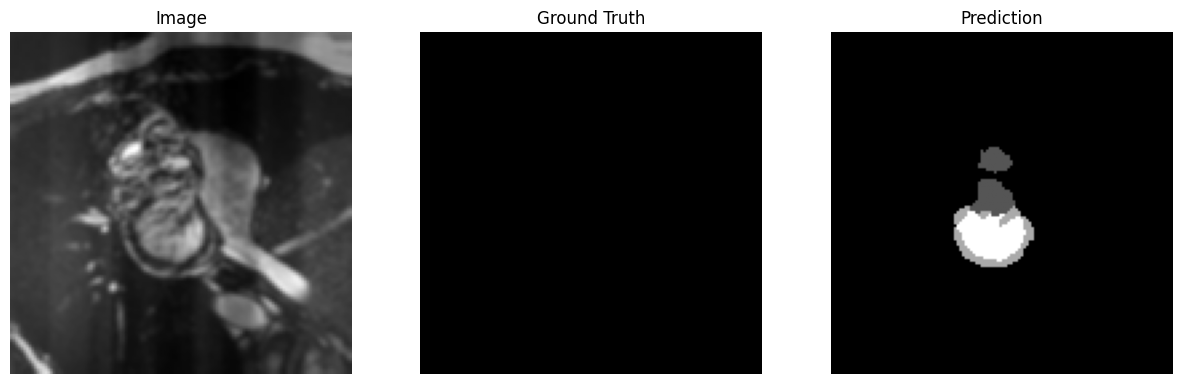

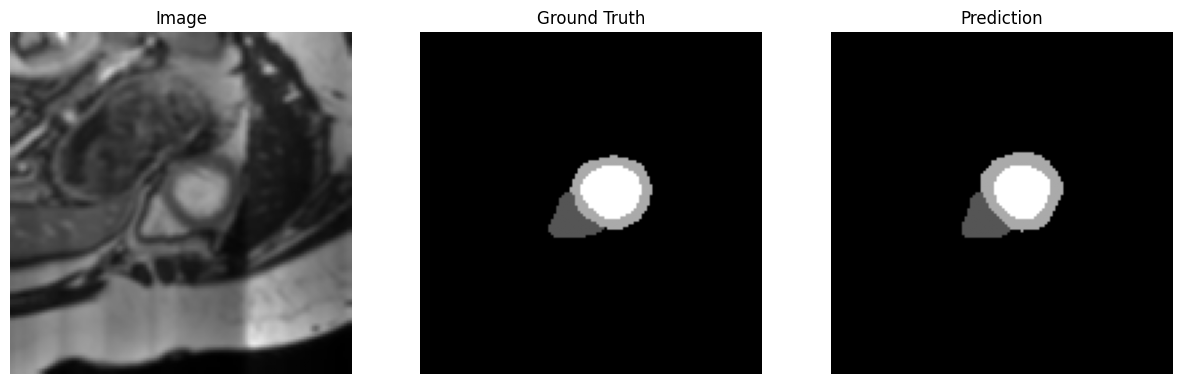

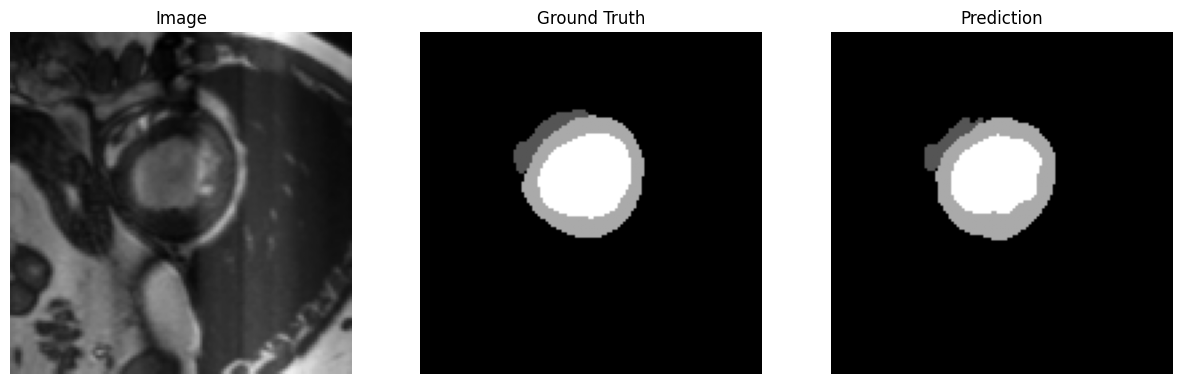

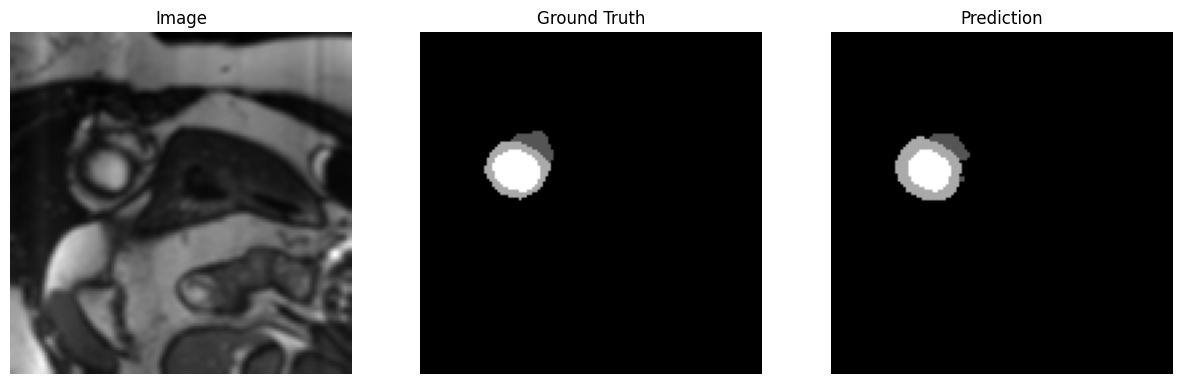

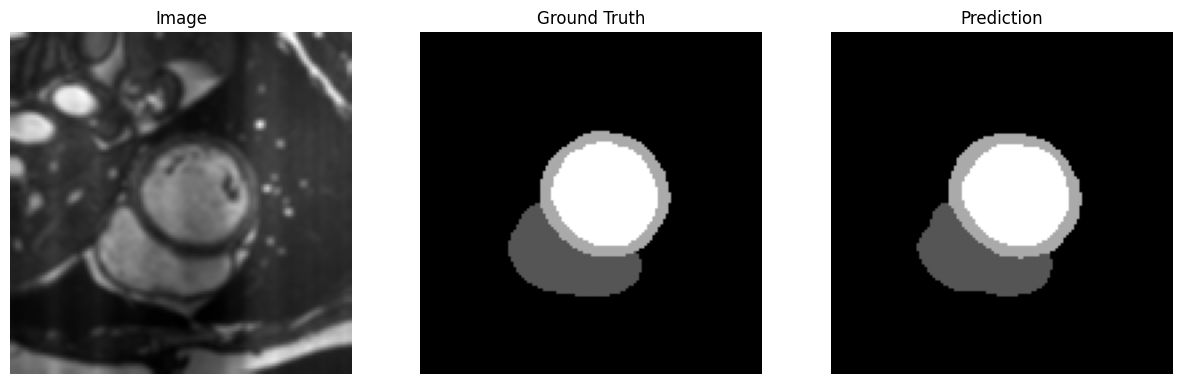

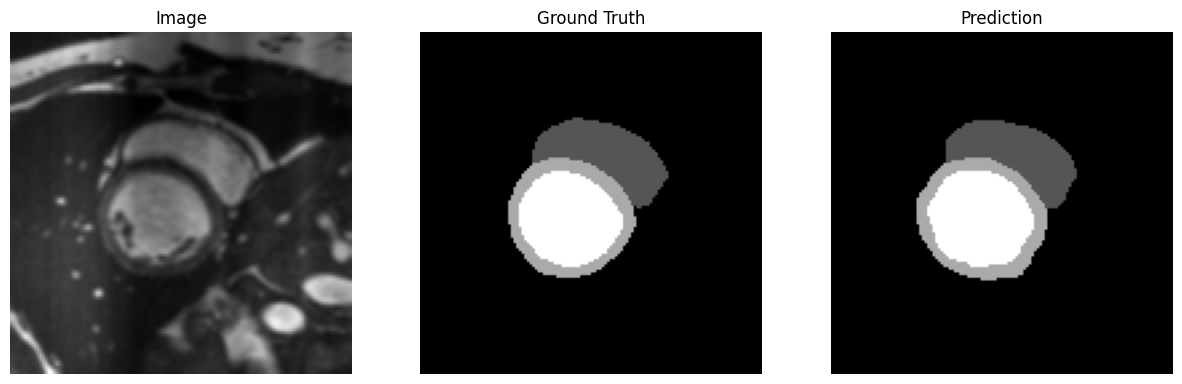

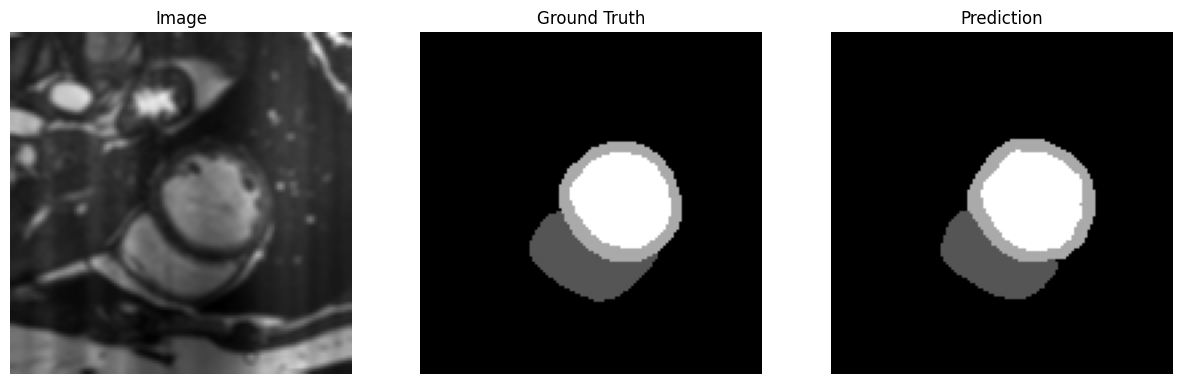

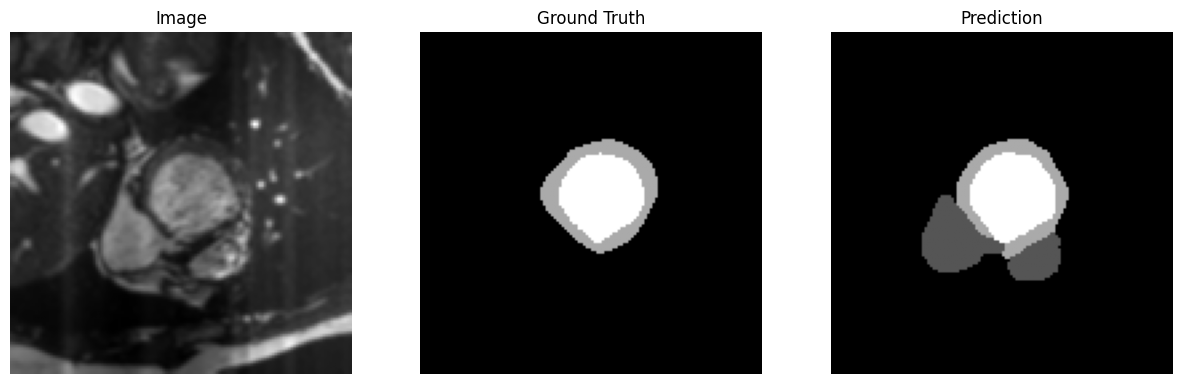

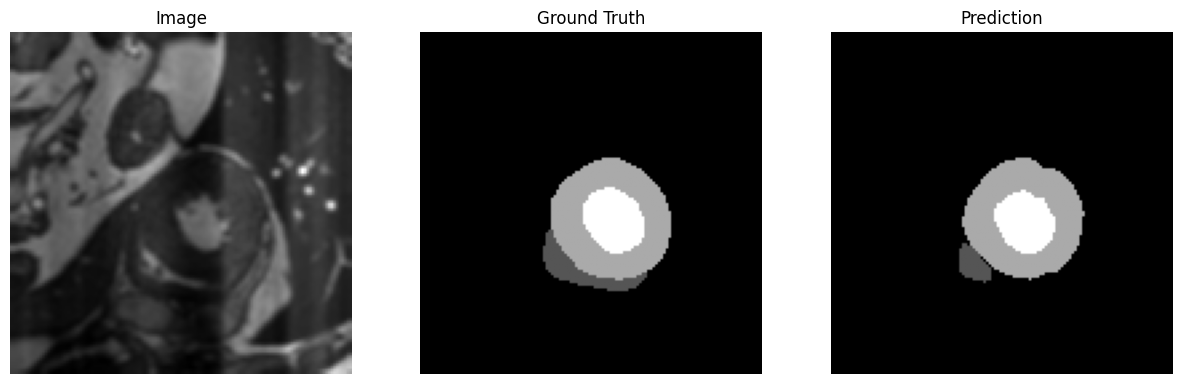

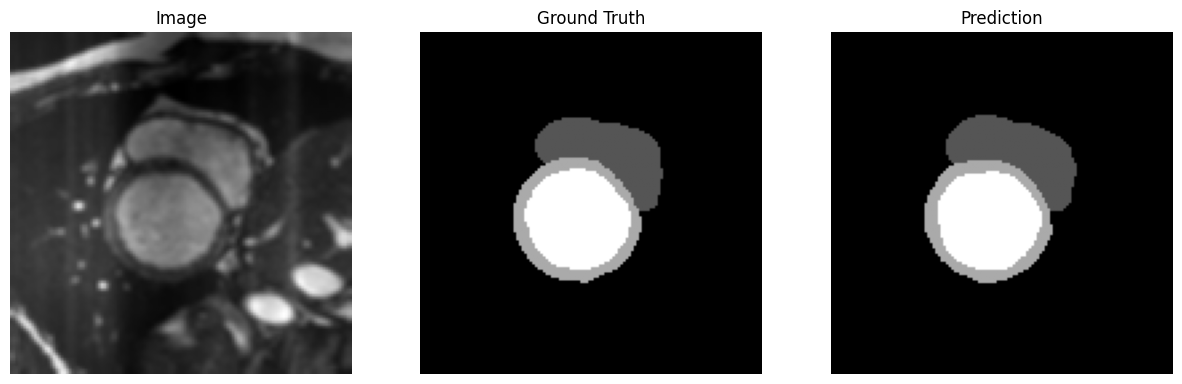

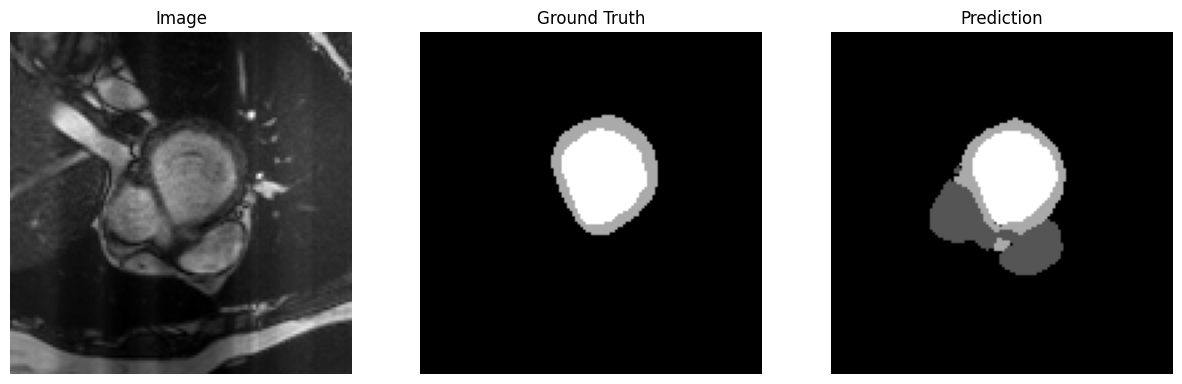

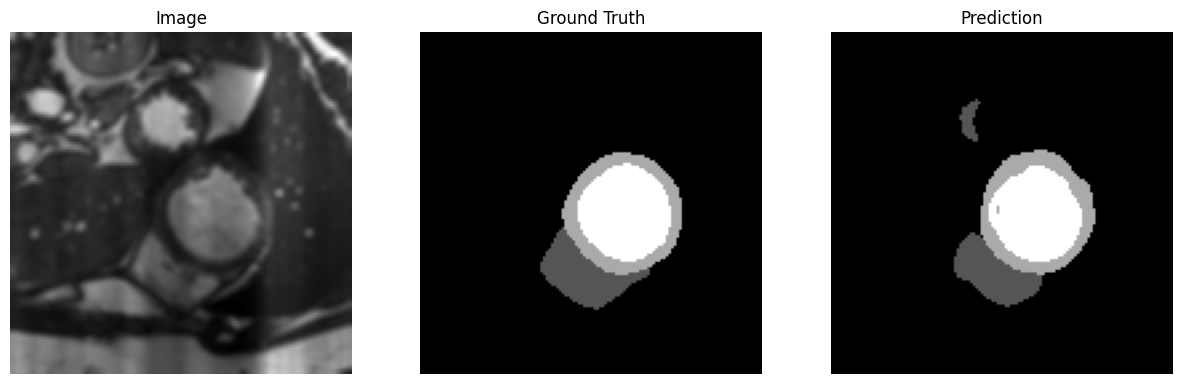

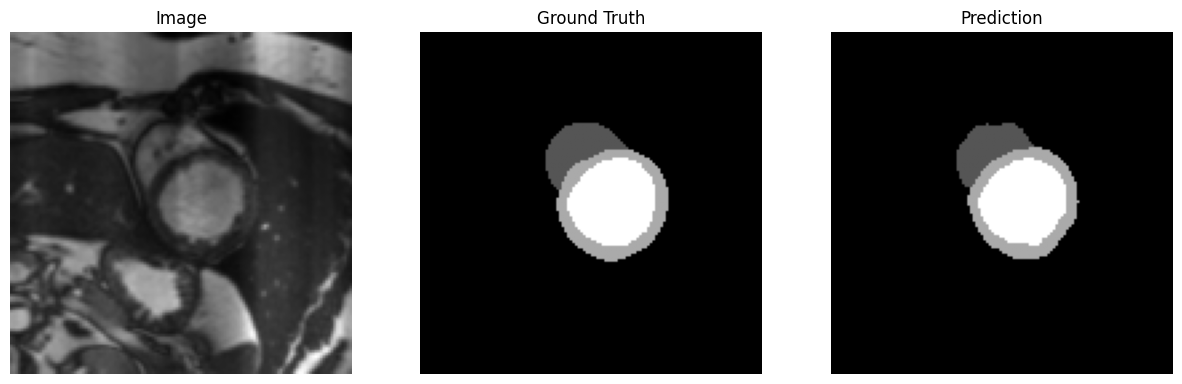

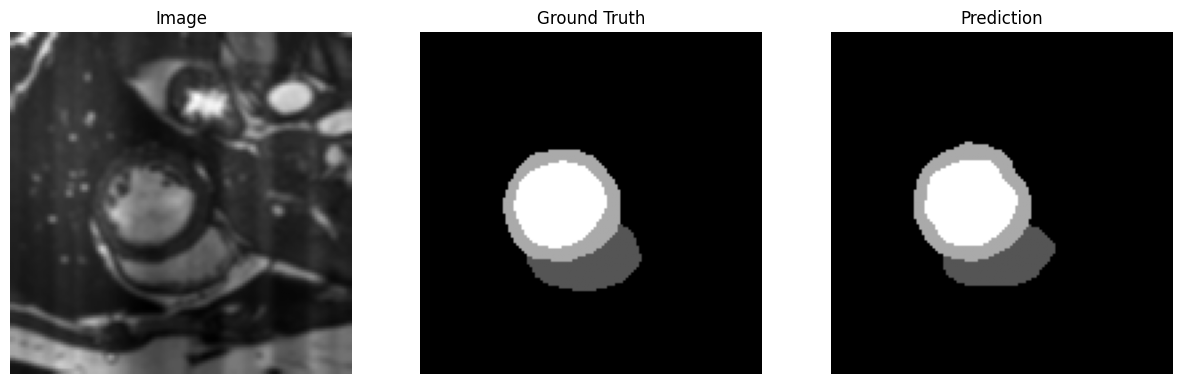

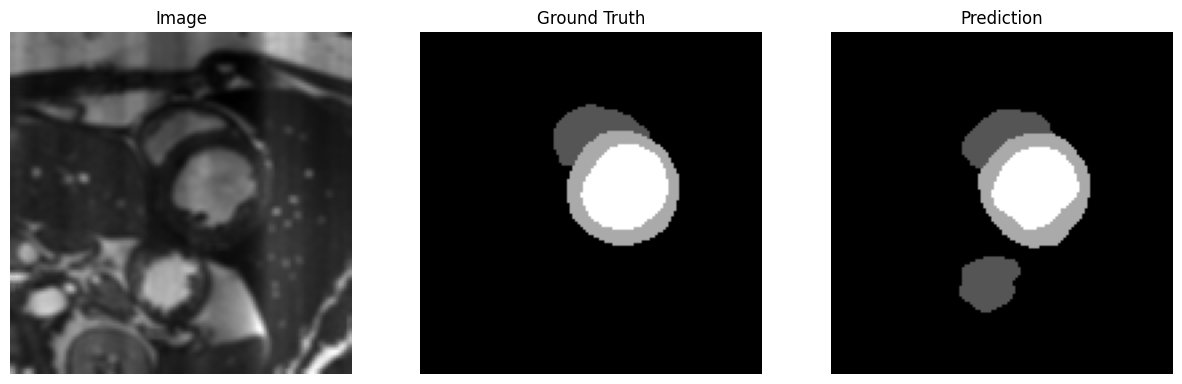

In [ ]:
import torch
import torch.optim as optim
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import cv2

# ModelInfo named tuple to store model class and its initialization arguments
ModelInfo = namedtuple('ModelInfo', ['model_class', 'init_args'])

# List of models to train
# TO DO: Implementing one other network to test here. You should be able to add it here for easy training.
models_to_train = [
    ModelInfo(UNet_v1, {})
]

def train_models(models_to_train, data, device, batch_size=64, epochs=10, lr=0.0005, weight_decay=0.0001, visualize_indices=None):
    results = {}

    # Define the loss function
    loss_fn = ComposeLoss(
        losses=[
            WeightedDiceLoss(weights=[0.5, 4, 3, 1]),
            EmptyPenaltyLoss(),
            LVPenaltyLoss(),
        ],
        weights=[2.0, 0.2, 1.0]
    )

    # Hey you should plot these
    metric = {
        'RV Dice': ClassDice(channel=1),
        'MYO Dice': ClassDice(channel=2),
        'LV Dice': ClassDice(channel=3),
        'F1 Score': F1Score(),
        'IoU': IoU(),
        'Sensitivity': Sensitivity(),
        'Specificity': Specificity(),
        'Precision': Precision(),
    }

    for model_info in models_to_train:
        model_name = model_info.model_class.__name__
        print(f"\nTraining {model_name}...")

        # Initialize the model
        model = model_info.model_class(**model_info.init_args).to(device)
        optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9)

        # Train the model
        train_data = train(
            DATASET=data,
            MODEL=model,
            LOSS=loss_fn,
            OPTIM=optim,
            METRIC=metric,
            DEVICE=device,
            BATCH_SIZE=batch_size,
            EPOCHS=epochs,
            SAVE_DATA=False,
            SCHEDULER=scheduler
        )

        # Save the results
        results[model_name] = train_data
        print(f"Finished training {model_name}.\n")

        # Visualize predictions if indices are provided
        if visualize_indices:
            print(f"\nVisualizing predictions for {model_name}...\n")
            visualize_predictions(model, data, visualize_indices, device)

    return results

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# TO DO: Pick data augmentation and transforms
pass

data = ACDC_2D_Dataset(
    "/content/drive/MyDrive/database/test.csv",
    "/content/drive/MyDrive/database",
    joint_transform=joint_transform,
    image_transform=image_transform,
    train=False,
)
# ^^^ heyo that won't run unless you define joint_transform and image_transform

# Indices of images you want to visualize
visualize_indices = [10, 25, 42, 9, 2, 3, 4, 11, 47, 1, 0, 5, 6, 14, 15]

# Training and visualizing results
results = train_models(models_to_train, data, device, batch_size=64, epochs=30, visualize_indices=visualize_indices)